# Logistic Regression

We will perform logistic regression using `satisfaction` variable as dependent variable and rest of the variables as the independent variable.

To get there, we need to prepare the data.

1. `one hot encode` the categorical columns
2. `remove missing` values
3. optionally `scale` the numerical columns

## Loading the data

Lets read in the csv file

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv("/kaggle/input/airline-passenger-satisfaction/train.csv")

In [ ]:
df.head()

There are 25 columns out of which `2` i.e `Unnamed: 0` and `id` are useless for our analysis. Lets separate out the columns into `categorical` and `numerical` so that we can pre process them separately.

In [ ]:
df.columns

In [ ]:
y_col = ["satisfaction"]
useless_cols = ["Unnamed: 0" , "id"]
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = df.select_dtypes(include=numerics)
numeric_cols = [f for f in newdf.columns if f not in useless_cols]
cat_cols = list(set(df.columns).difference(set(useless_cols).union(set(numeric_cols))))
cat_cols = [c for c in cat_cols if c not in y_col]

In [ ]:
numeric_cols

In [ ]:
cat_cols

We now `one hot` encode the categorical columns. We can use `pandas.get_dummies` method for that. 

This is what one hot encoding looks like


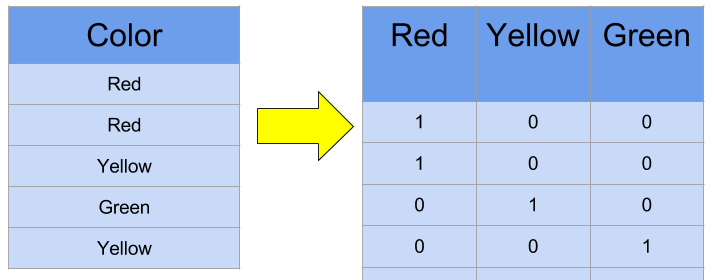

[source](https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding)

One important thing note is that we use `drop_first` property to drop the first value of each categorical column and keep the rest. This is done to avoid `multi-collinearlity` or the `dummy variable trap`. [More here](https://www.geeksforgeeks.org/ml-dummy-variable-trap-in-regression-models/)

So in the above example we would drop `red` column. This also sets the dropped value as the `reference` category. Now the coeficients of `yellow` and `green` ,produced by the logit model , can be interpreted in terms of `red` , for example how more likely is `yellow` to `satisfy` the passengers compared to `red`

In [ ]:
encoded_cat_df = pd.get_dummies(df[cat_cols] , drop_first =True)

We assign all our independent variables to `X` and the dependent variable to `y`

In [ ]:
X = encoded_cat_df.join(df[numeric_cols])
#X= encoded_cat_df
y = df[y_col]

In [ ]:
X

Finall to fill in the `missing` values we use `dataframe.fillna` method and `impute` the columns with their respective means

In [ ]:
X.loc[: , numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].mean())

One thing we have to do for our independent variables is to `manually` add a `constant` variable for which `statmodels` will find the coeficient. Statmodels provides a helper function `sm.add_constant` which adds a column to our data with a constant value of 1

In [ ]:
import statsmodels.api as sm 

In [ ]:
X = sm.add_constant(X)

`Statsmodels` logit class expects that the dependent variable be `0 or 1` and therefore we use `numpy.where` to convert our `satisfied or dissatisfied` to 0 and 1. We set `satisfied` to 1.

In [ ]:
np.where(y == "satisfied" , 1, 0)

Lets run the Logit model

In [ ]:
log_reg = sm.Logit(np.where(y == "satisfied" , 1, 0), X).fit_regularized() 

Lets look at the results

In [ ]:
log_reg.summary()

## Overall Model Significance

Few of the crucial metrics to look at are
1. `log-likelihood (ll)` - to interpret the overall significance of the model we look at the `ll` of our model vs `ll` of the `null` model
    - The null model,contains just the intercept. So the intercept is the log-odds of "success", estimated without reference to any predictors.
    - This metric gives insight into how informative our independent variables are.
    - Since a *good* model would mean that the liklihood of seeing our data generated by the model is high (closer to 1) therefore `log(liklihood)` should be closer to 0
    - If `ll` of our model is closer to 0 than the `ll` of the null model then we have a *good* model
    - in this case `ll` of our model is ~ -34,000 and `ll` of the null model is ~ -71,000 with a p-val of 0.0 therefore we have a significant model.

2. `Pseudo-R-sqr` - unlike in linear regression, there is no straightforward way to calculate `r^2` in logistic regression and therefore there are many other metrics that try to present similar information and have similar range (0-1). These metrics fall under the category of `pseudo-r-sqr`. There are many of these - one such list is [here](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-pseudo-r-squareds/)
    -A value closer to 1 would mean that our independent variables "explain" most of the variation in the dependent variable. A value closer to 0 would mean that the independet variables help explain nothing about the dependent variable.
    - In this case the value is 0.46 and therefore we don't have much explanatory power in our dependent variables and would need more (external) information about our passengers to determine what makes them `satisfied`
   

## Variable Interpretations

First thing to do is to isolate the variables which are statistically significant. In this case (weirdly enough) most variables turn out to be statistically significant as their `p-values` are 0 or close to zero. Only `flight distance` seems to be a statistically insignificant variable at 95% confidence interval.


Now even though a lot of variables might be statistically significant, we still need to assess their impact on the dependent variable. For that we focus on the `coef` values. But directly staring at the coef values is not that informative and therefore we first convert the coeficients into `log-odds`

Since we assume that the variables are independent of each other, so we can look at each individually.

Recall that logistic regression equation is 

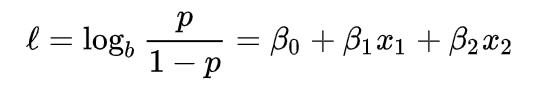

Therefore suppose we want to interpret the impact of variable `x1` on how `satisfied` it makes a person, since all variables are independent we can keep them constant and *ignore* them. 

This will reduce the equation to 

`log(odds) = B1*x1`

then we can move the log to the other side

`odds = exp(B1 * x1)`

now we can safely interpret the change in odds of someone being `satisfied` or `dissatisfied` by looking at the exponent of the coeficient of the `x1` variable.

More concretly, lets take the exponent of all coeficients we have.


In [ ]:
np.exp(log_reg.params)

Now suppose we want to see how `Type of Travel` impacts the `satisfaction` level.

Lets look at the `exp(coeficient of type of travel)`.
The value is `0.0704`. Now thing to remember is that the reference category for type of travel is `Business Travel`. So the way to interpret this is that `Personal Travel` reduces the odds of being `satisfied` compared to `Business Travel`. 

People who are on personal travel are `(1-0.07)*100 = 93%` less likely to be satisfied compared to people on business travel. That was surprising right ? Duh. 